In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

font = {'size':14}
plt.rc('font', **font)

In [2]:
import numpy as np

In [3]:
# need some waveforms
# across mass-ratio and spin

In [4]:
import pycbc
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import amplitude_from_frequencyseries, phase_from_frequencyseries
from pycbc import pnutils

In [5]:
import phenom

In [6]:
qlist = np.linspace(1, 5, 5)
clist = np.linspace(0, 1, 5)

In [7]:
def make_regular_2d_grid(xlist, ylist):
    x, y = np.meshgrid(xlist, ylist)
    return x.reshape(1,-1)[0], y.reshape(1,-1)[0]

def make_regular_3d_grid(xlist, ylist, zlist):
    x, y, z = np.meshgrid(xlist, ylist, zlist)
    return x.reshape(1,-1)[0], y.reshape(1,-1)[0], z.reshape(1,-1)[0]

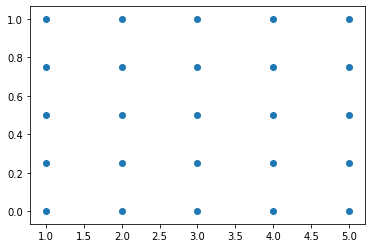

In [8]:
x, y = make_regular_2d_grid(qlist, clist)
plt.figure()
plt.scatter(x.reshape(1,-1)[0], y.reshape(1,-1)[0])

In [9]:
x, y, z = make_regular_3d_grid(qlist, clist, clist)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x.reshape(1,-1)[0], y.reshape(1,-1)[0], z.reshape(1,-1)[0])

In [10]:
def mask_array(x, y, x1, x2):
    mask = (x>=x1) & (x<=x2)
    newx = x[mask]
    newy = y[mask]
    return newx, newy

In [11]:
def make_training_set(qlist, clist, f_lower=30, delta_f=1,
                     approximant="IMRPhenomD",
                     mtot=100,
                     fstart=30, fend=200, align_phase=True):
    
    x, y = make_regular_2d_grid(qlist, clist)
    npts = len(x)
    
    amp = [None]*npts
    phase = [None]*npts
    
    coords = []
    
    for i, (q, c) in enumerate(zip(x,y)):
        print(i, q, c)
        coords.append([q,c])
        m1,m2 = phenom.m1_m2_M_q(mtot, q)
        hp, _ = get_fd_waveform(mass1=m1,
                                mass2=m2,
                                spin1z=c,
                                delta_f=delta_f,
                                f_lower=f_lower,
                                approximant=approximant)
        amp_ts = amplitude_from_frequencyseries(hp)
        phase_ts = phase_from_frequencyseries(hp)
        
        if i==0:
            flist, amp[i] = mask_array(amp_ts.sample_frequencies, amp_ts.data, fstart, fend)
        else:
            _, amp[i] = mask_array(amp_ts.sample_frequencies, amp_ts.data, fstart, fend)
            
        _, phi_tmp = mask_array(phase_ts.sample_frequencies, phase_ts.data, fstart, fend)
        if align_phase == True:
            #aligned phase
            #subtract off a linear function over the freq interval [fstart, fend]
#             z = np.polyfit(flist[flist<100], phi_tmp[flist<100], 1)
            z = np.polyfit(flist, phi_tmp, 1)
            p = np.poly1d(z)
            phi_tmp -= p(flist)

#         _, phase[i] = mask_array(phase_ts.sample_frequencies, phase_ts.data, fstart, fend)
        phase[i] = phi_tmp
#         phase[i] = phi_tmp * phenom.eta_from_q(q)
#         phase[i] = phi_tmp / q
        
    return np.array(coords), np.array(flist), np.array(amp), np.array(phase)

In [12]:
coords, f, am, ph = make_training_set(qlist, clist)

0 1.0 0.0
1 2.0 0.0
2 3.0 0.0
3 4.0 0.0
4 5.0 0.0
5 1.0 0.25
6 2.0 0.25
7 3.0 0.25
8 4.0 0.25
9 5.0 0.25
10 1.0 0.5
11 2.0 0.5
12 3.0 0.5
13 4.0 0.5
14 5.0 0.5
15 1.0 0.75
16 2.0 0.75
17 3.0 0.75
18 4.0 0.75
19 5.0 0.75
20 1.0 1.0
21 2.0 1.0
22 3.0 1.0
23 4.0 1.0
24 5.0 1.0


In [13]:
coords[:,0]

array([1., 2., 3., 4., 5., 1., 2., 3., 4., 5., 1., 2., 3., 4., 5., 1., 2.,
       3., 4., 5., 1., 2., 3., 4., 5.])

In [14]:
coords[:,1]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 1.  , 1.  ,
       1.  , 1.  , 1.  ])

In [15]:
plt.figure()
for i in range(len(ph)):
    plt.plot(f, ph[i])

In [16]:
def compute_svd(matrix):
    u, s, vh          = np.linalg.svd(matrix, full_matrices=False)
    return u,s,vh

In [17]:
ph.shape

(25, 171)

In [18]:
u,s,vh = compute_svd(ph)
# u,s,vh = compute_svd(am)

In [19]:
print("u.shape = {0}".format(u.shape))
print("s.shape = {0}".format(s.shape))
print("vh.shape = {0}".format(vh.shape))

u.shape = (25, 25)
s.shape = (25,)
vh.shape = (25, 171)


In [20]:
s

array([1.69546547e+02, 5.91414781e+00, 3.06831815e+00, 1.58956318e+00,
       5.21434404e-01, 2.38753208e-01, 5.93488403e-02, 2.83807417e-02,
       1.93005791e-02, 8.67482420e-03, 6.43233017e-03, 2.69343938e-03,
       1.38431676e-03, 8.34009377e-04, 7.59670483e-04, 5.87122339e-04,
       4.32222969e-04, 3.92113573e-04, 2.16038967e-04, 1.91972026e-04,
       7.29087314e-05, 6.87371544e-05, 3.88115466e-05, 2.84797885e-05,
       1.84254233e-05])

In [21]:
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
plt.semilogy(range(len(ph)),s,'b+', label='singular values')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc='best')

In [22]:
plt.plot(vh[0])

In [23]:
# Decide on how many column vectors to use as the basis
# basis_size = 3
# basis_size = 4
basis_size = 5
# basis_size = 6
# basis_size = 7
# More vectors -> more accuracy but also more computational cost 
# basis_size = -1
basis_set  = vh[0:basis_size,:]

In [24]:
def compute_projection_coeffs(RB, ref_data):
    proj_coeffs = np.array([ np.dot(RB, ref_data[i]) for i in range(len(ref_data)) ] )
    return proj_coeffs

In [25]:
proj_coeffs = compute_projection_coeffs(basis_set, ph)

In [26]:
proj_coeffs.shape

(25, 5)

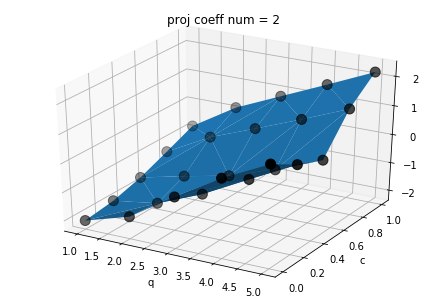

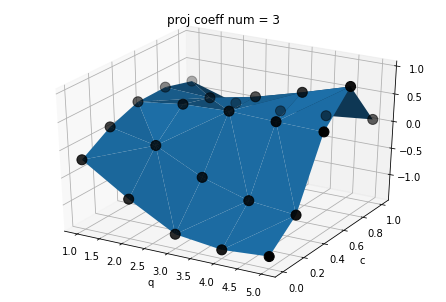

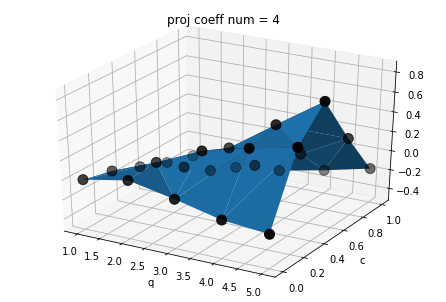

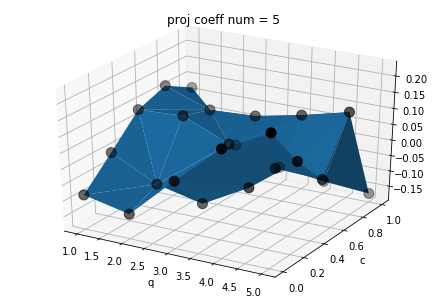

In [27]:
for i in range(basis_size):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.plot_trisurf(coords[:,0], coords[:,1], proj_coeffs[:,i])
    ax.scatter(coords[:,0], coords[:,1], proj_coeffs[:,i], s=100, c='k')
    ax.set_xlabel('q')
    ax.set_ylabel('c')
    ax.set_title('proj coeff num = {0}'.format(i+1))

In [28]:
def test_reduced_basis(flist, ref_data, idx, coords, RB):
    ref_data=ref_data[idx]
    # compute projection coefficient
    proj_coeffs = np.dot(RB, ref_data)
    # compute representation in linear space defined by the span of the basis set
    approx_data = np.dot(proj_coeffs, RB)
#     approx_data = approx_data.transpose()
    
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    fig.suptitle('idx = {0}, q = {1:.3f}, c = {2:.3f}'.format(idx, coords[idx][0], coords[idx][1]), fontsize=12)

    axes[0].plot(flist, ref_data, label='ref data')
    axes[0].plot(flist, approx_data, label='approx data')
    axes[0].legend()
    
    err = np.abs(ref_data - approx_data)
    axes[1].plot(flist, err, label='err')
    axes[1].set_yscale('log')
    axes[1].legend()
    
    plt.show()

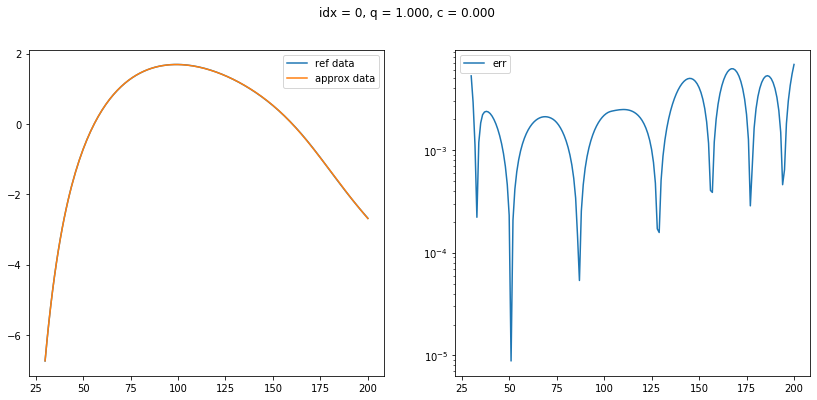

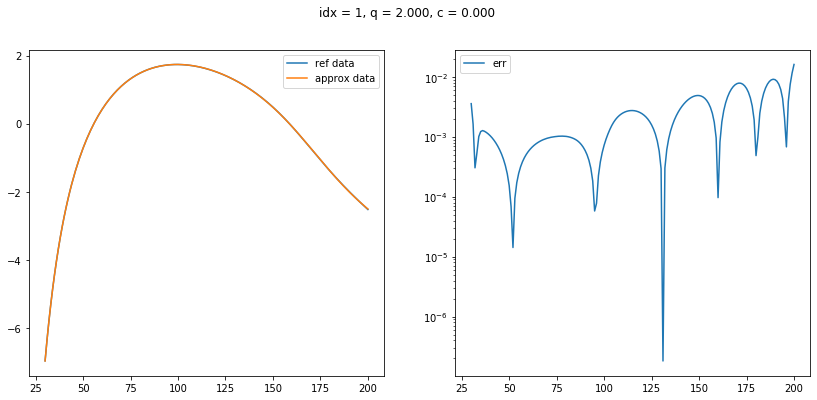

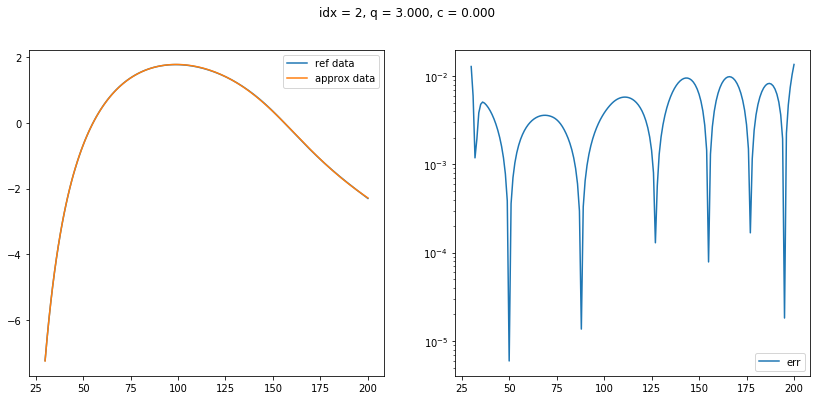

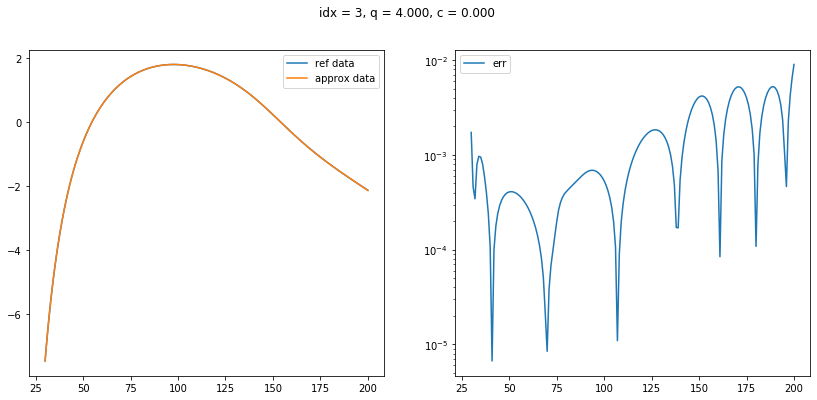

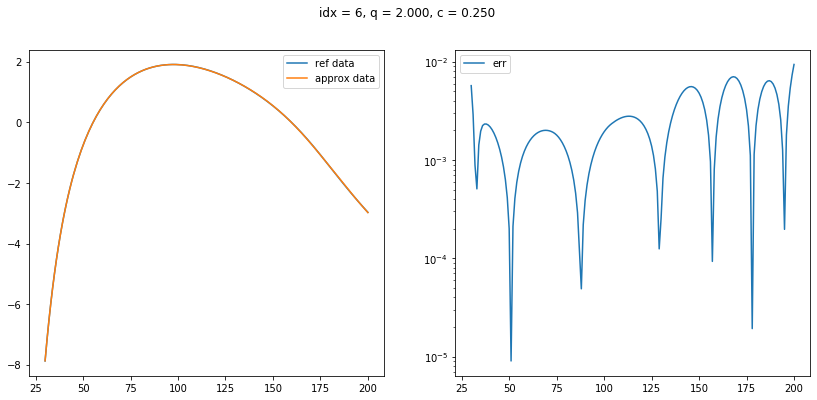

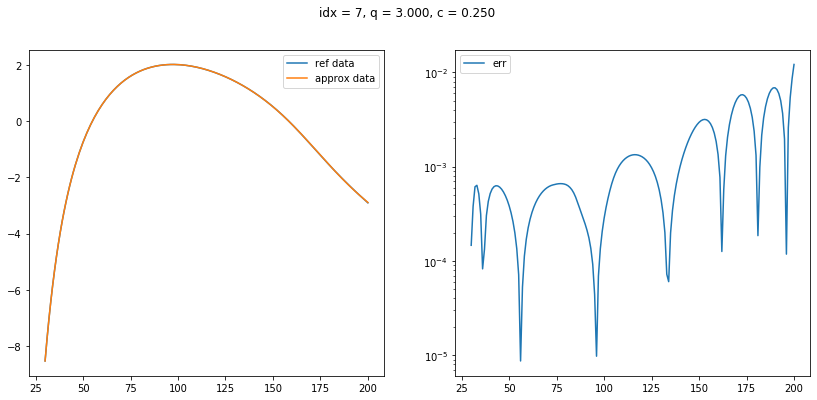

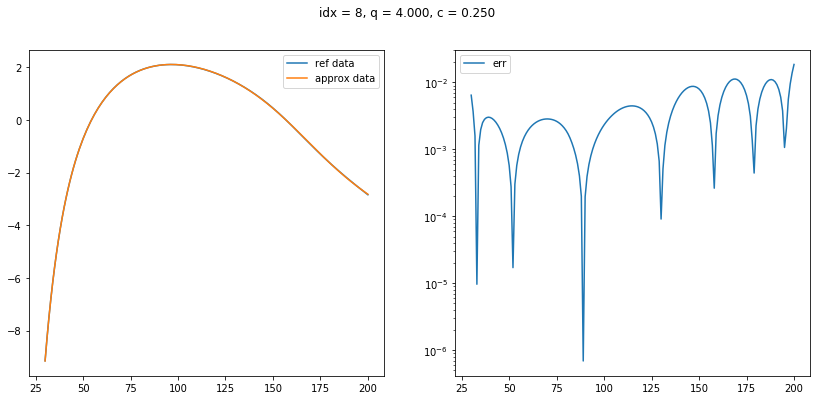

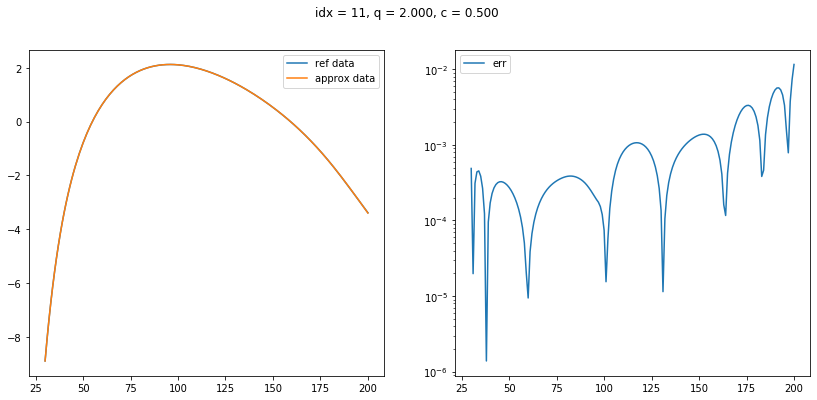

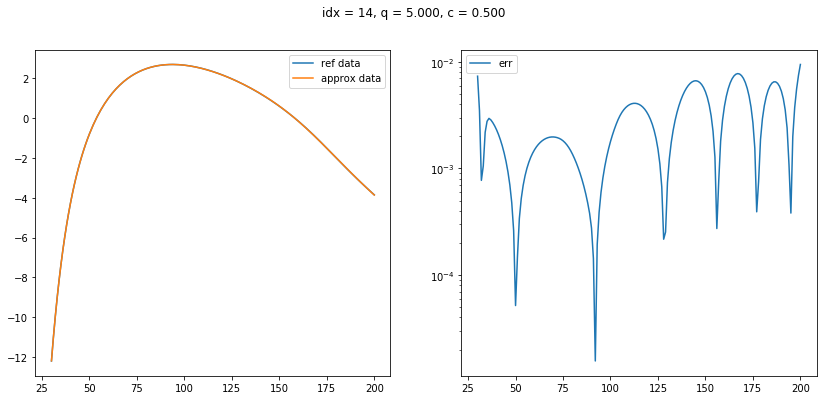

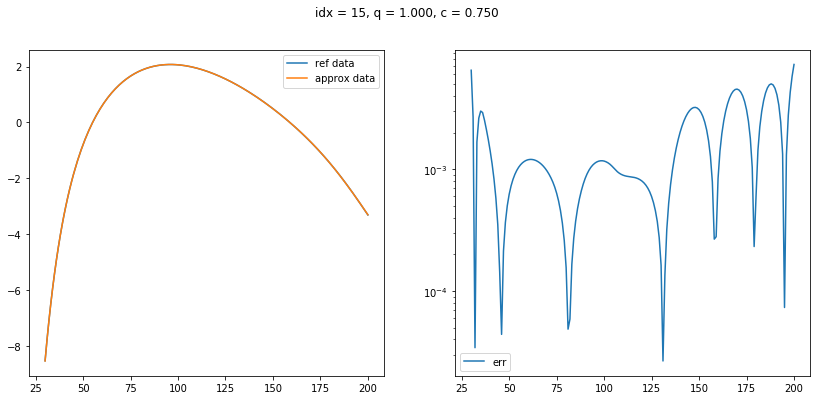

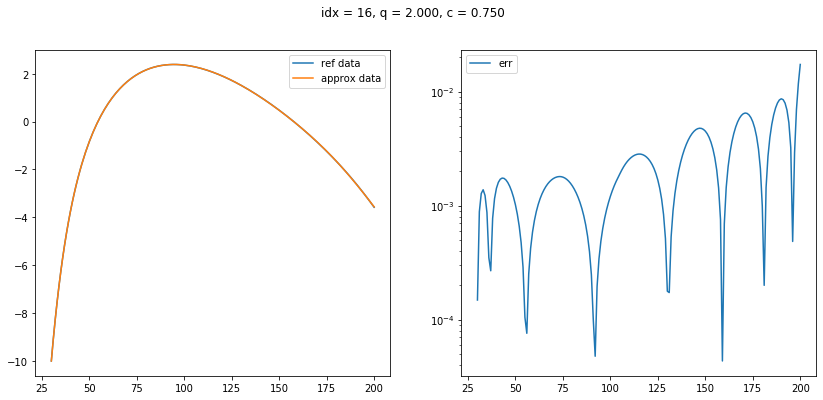

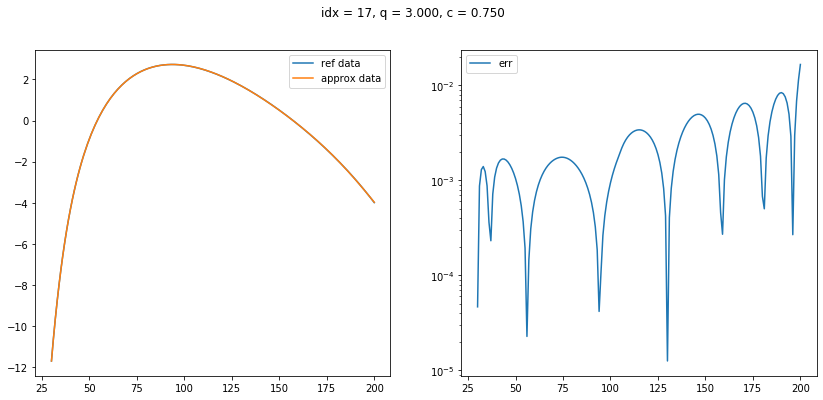

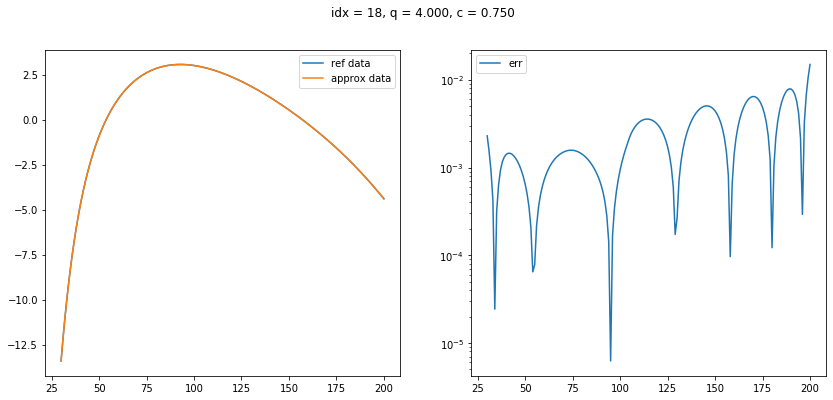

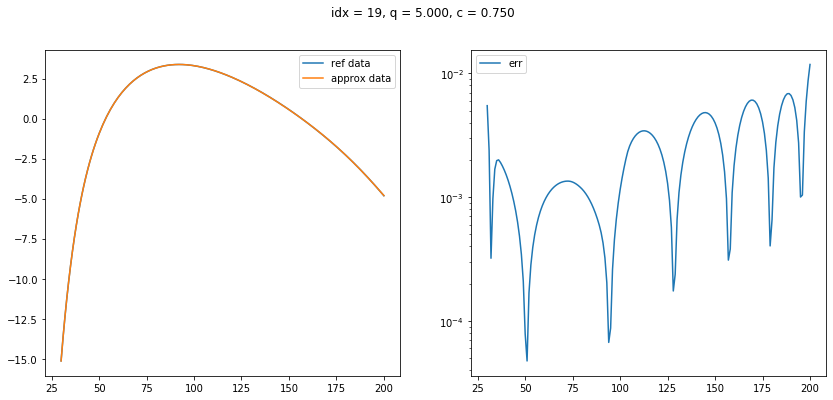

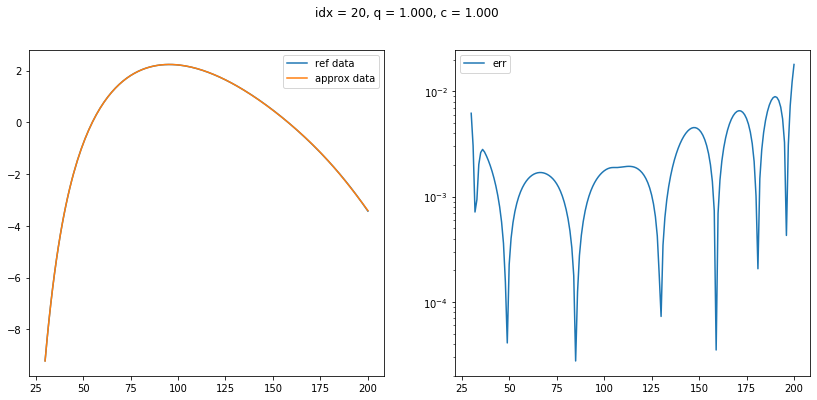

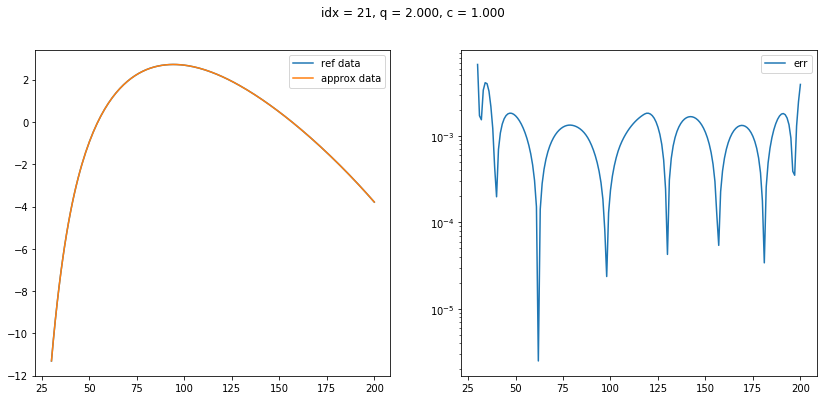

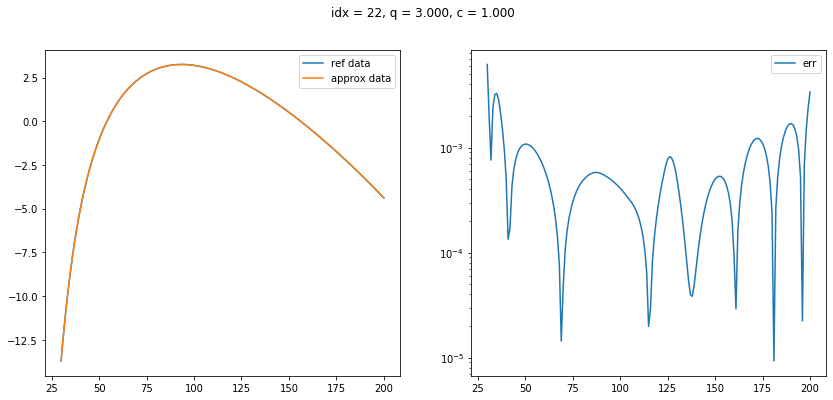

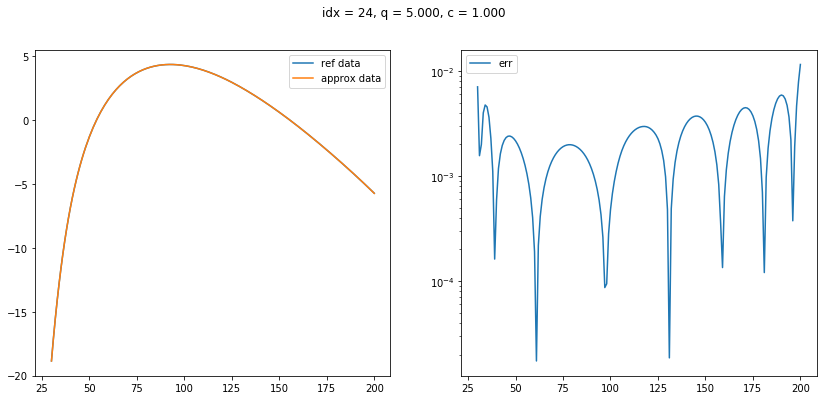

In [29]:
for i in range(len(ph)):
    test_reduced_basis(f, ph, i, coords, basis_set)

# make a fit of the projection coefficients

In [30]:
coords[:,0]
coords[:,1]
proj_coeffs[:,0]

array([-22.89193914, -23.34245307, -23.5913783 , -23.66592452,
       -23.72030783, -24.46713656, -26.05093628, -27.592237  ,
       -28.81640704, -29.87192817, -26.1543594 , -28.92852153,
       -31.99572007, -34.81117889, -37.41341888, -27.98772034,
       -32.13116499, -36.83252527, -41.51663549, -46.15065662,
       -30.03824596, -36.17248661, -43.27116628, -50.68877326,
       -58.3259422 ])

In [31]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [32]:
coords.shape

(25, 2)

In [33]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# https://github.com/dmlc/xgboost/issues/1715

In [67]:



model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(2,), kernel_initializer='glorot_uniform'))
model.add(Dense(500, kernel_initializer='normal', activation='relu'))
# model.add(Dense(500, kernel_initializer='normal', activation='relu'))
# model.add(Dense(500, kernel_initializer='normal', activation='relu'))
# model.add(Dense(500, kernel_initializer='normal', activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model.fit(x=coords, y=proj_coeffs[:,0], epochs=1000, verbose=1)


X = np.column_stack(([1], [0]))
print(model.predict(X))

X = np.column_stack((coords[0][0], coords[0][1]))
print(model.predict(X))

print(proj_coeffs[0,0])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 501       
Total params: 252,501
Trainable params: 252,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
25/25 [==============================] - 0s 18ms/step - loss: 1161.7169 - mse: 1161.7169 - mae: 32.8268
Epoch 2/1000
25/25 [==============================] - 0s 227us/step - loss: 1113.4362 - mse: 1113.4362 - mae: 32.1304
Epoch 3/1000
25/25 [==============================] - 0s 206us/step - loss: 1070.5214 - mse: 1070.5214 - mae: 31.4980
Epoch 4/1000
25/25 [=====

In [68]:
X.shape

(1, 2)

In [69]:
coords.shape

(25, 2)

In [70]:
coords[0].reshape(1,2)

array([[1., 0.]])

In [71]:
model.predict(coords)

array([[-19.708689],
       [-21.279066],
       [-21.974586],
       [-22.760208],
       [-23.571857],
       [-22.412489],
       [-27.878433],
       [-29.190475],
       [-29.80835 ],
       [-30.593971],
       [-25.057564],
       [-31.025454],
       [-36.048176],
       [-37.101883],
       [-37.64707 ],
       [-27.702644],
       [-33.67053 ],
       [-39.638416],
       [-44.217922],
       [-45.01329 ],
       [-30.347717],
       [-36.315605],
       [-42.283493],
       [-48.25138 ],
       [-52.379513]], dtype=float32)

In [72]:
zhat = model.predict(coords)[:,0]

In [73]:
plt.figure()
plt.scatter(coords[:,0], (zhat - proj_coeffs[:,0])/zhat * 100)